In [106]:
import glob
import csv
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Task 1-2

Разделение загруженного набора данных на обучающую, тестовую и валидационую выборки

In [107]:
images_list = []
images_list = glob.glob(os.path.join('dataset3','*.jpg'))
train_list = images_list[0 : int(len(images_list)*0.8)]
test_list = images_list[int(len(images_list)*0.8) : int(len(images_list)*0.9)]
val_list = images_list[int(len(images_list)*0.9) : int(len(images_list))]

Проверка списков

In [108]:
print(len(images_list))
print(images_list[:5])
    
print(len(train_list))
print(train_list[:5])
    
print(len(test_list))
print(test_list[:5])
    
print(len(val_list))
print(val_list[:5])

2000
['dataset3/4217.jpg', 'dataset3/2100.jpg', 'dataset3/2672.jpg', 'dataset3/8411.jpg', 'dataset3/5653.jpg']
1600
['dataset3/4217.jpg', 'dataset3/2100.jpg', 'dataset3/2672.jpg', 'dataset3/8411.jpg', 'dataset3/5653.jpg']
200
['dataset3/4948.jpg', 'dataset3/6187.jpg', 'dataset3/3772.jpg', 'dataset3/8627.jpg', 'dataset3/7272.jpg']
200
['dataset3/6976.jpg', 'dataset3/7498.jpg', 'dataset3/3826.jpg', 'dataset3/2286.jpg', 'dataset3/1943.jpg']


Проверка картинок

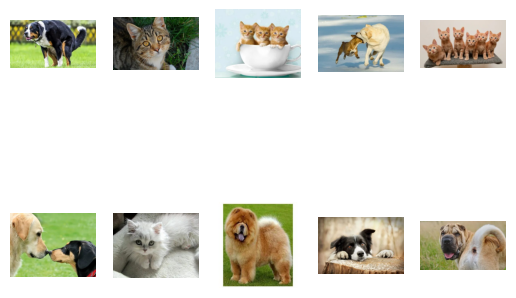

In [109]:
random_idx = np.random.randint(1,len(images_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')


plt.show()

Класс dataset, который будет хранить загруженные и преобразованные изображения и метки классов

In [111]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[1]
        if label == 'cats':
            label=0
        elif label == 'dogs':
            label=1
       
            
        return img_transformed,label

# Task 4

Пайплайн предобработки данных

In [92]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

test_transforms = transforms.Compose([   
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

In [93]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.8196, 0.8157, 0.8078,  ..., 0.2196, 0.2863, 0.3137],
         [0.8196, 0.8157, 0.8078,  ..., 0.2314, 0.2941, 0.3216],
         [0.8118, 0.8078, 0.8000,  ..., 0.3333, 0.3922, 0.4157],
         ...,
         [0.2784, 0.2667, 0.2392,  ..., 0.7725, 0.7686, 0.7686],
         [0.2706, 0.2588, 0.2275,  ..., 0.7804, 0.7765, 0.7765],
         [0.2706, 0.2588, 0.2275,  ..., 0.7804, 0.7765, 0.7765]],

        [[0.6784, 0.6745, 0.6667,  ..., 0.2745, 0.3412, 0.3686],
         [0.6784, 0.6745, 0.6667,  ..., 0.2863, 0.3529, 0.3765],
         [0.6706, 0.6667, 0.6588,  ..., 0.3922, 0.4471, 0.4745],
         ...,
         [0.1922, 0.1804, 0.1490,  ..., 0.8392, 0.8353, 0.8353],
         [0.1843, 0.1725, 0.1412,  ..., 0.8471, 0.8431, 0.8431],
         [0.1843, 0.1725, 0.1412,  ..., 0.8471, 0.8431, 0.8431]],

        [[0.5529, 0.5490, 0.5333,  ..., 0.3216, 0.3961, 0.4275],
         [0.5529, 0.5490, 0.5333,  ..., 0.3333, 0.4078, 0.4392],
         [0.5412, 0.5373, 0.5216,  ..., 0.4549, 0.5176, 0

# Task 3


In [94]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method

загрузка набора данных в dataloader

In [95]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True )

test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                         batch_size=batch_size, 
                                         shuffle=False)

In [96]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

1600 16
200 2


torch.Size([3, 224, 224])

Модель сверточной нейросети для решения задачи классификации

In [97]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.Flatten()(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return torch.nn.Sigmoid()(out)

# Task 5


In [98]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

print(device)
    
model = Cnn().to(device)

cpu


In [99]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.BCELoss()

Цикл обучения нейросети

In [100]:
accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

def train_loop(train_loader, val_loader):
    epochs = 10
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())
        
        model.eval()
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label.unsqueeze(dim=1).to(torch.float))
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        val_accuracy_values.append(epoch_val_accuracy.item())
        val_loss_values.append(epoch_val_loss.item())
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        print('\n')

In [104]:
train_loop(train_loader, val_loader)

AttributeError: 'tuple' object has no attribute 'to'